In [69]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib 
from sqlalchemy import create_engine
from sshtunnel import SSHTunnelForwarder

%matplotlib inline 

In [70]:
''' 
bitconnect to the database 
'''
def get_db_connection():
    username = 'mig'
    password = 'password' 
    host_name = 'localhost'
    port = 5432
    db_name = 'mtg'
    conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)

    engine = create_engine(conn_str)
    return engine

In [71]:
def get_db_connection():
    
    '''
    close connections by doing 

    engine.dispose()
    server.close()
    '''
    server = SSHTunnelForwarder(
         ('mtgdata.ddns.net', 49000),
         ssh_password="red",
         ssh_username="mig",
         remote_bind_address=('127.0.0.1', 5432)
    )

    server.start()

    username = 'mig'
    password = 'password' 
    host_name = 'localhost'
    port = server.local_bind_port # assigned local port
    db_name = 'mtg'
    conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)

    engine = create_engine(conn_str)
    
    return engine, server

In [72]:
'''
read the records
'''

now = pd.Timestamp.now(tz='UTC').date()
now_minus_24_hours = now - pd.Timedelta('%d hours'%(24,))
engine, server = get_db_connection()

query = '''
SELECT *  
FROM card_listings;
'''#%(str(now_minus_24_hours), str(now))

df_db = pd.read_sql_query(query, engine)
engine.dispose()
server.close()

In [73]:
df_db.dtypes

card_name                         object
ts                        datetime64[ns]
list_order                         int64
seller_name                       object
seller_sales                       int64
seller_available_items             int64
item_price                       float64
item_amount                        int64
item_location                     object
item_condition                    object
item_language                     object
item_is_playset                     bool
item_is_foil                        bool
dtype: object

In [74]:
df_db.shape

(600415, 13)

In [75]:
df_db.head(1)

,card_name,ts,list_order,seller_name,seller_sales,seller_available_items,item_price,item_amount,item_location,item_condition,item_language,item_is_playset,item_is_foil
0,Fabled Passage,2019-10-11 07:03:14.258221,332,gpap1995,0,11,14.0,1,,NM,English,False,True


In [76]:
#fix the ts
def correct_ts(ts):
    minute = 0 if ts.minute < 30 else 30
    ts_corrected = pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, minute)
    return ts_corrected

def data_transformer(df):
    df = df.copy()
    df.ts = df.ts.map(correct_ts)
    df = df.drop('list_order', axis=1)
    df = df.set_index(['ts', 'card_name'])
    df = df.sort_index()
    return df

In [77]:
df = data_transformer(df_db)
idx = pd.IndexSlice
#the dates before '2019-10-10 23:00:00' have bad data, lets remove them
df = df.loc[idx[:'2019-10-10 23:00:00', :], :].head()

In [78]:
df.item_location.unique()

array([''], dtype=object)

In [58]:
df_xs = df.xs('Snow Covered Island', level='card_name', drop_level=True)

In [56]:
df_xs.loc['2019-10-13 13:30:00', 'item_amount'].sum()

8772

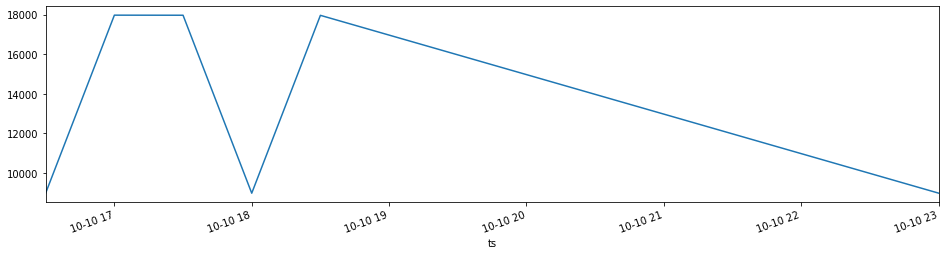

In [62]:
df_plot = df_xs.loc[:'2019-10-10 23:00:00', 'item_amount']
df_plot.groupby(df_plot.index).sum().plot(figsize=(16, 4), rot=20); 